#<center>Age and Gender Prediction</center>

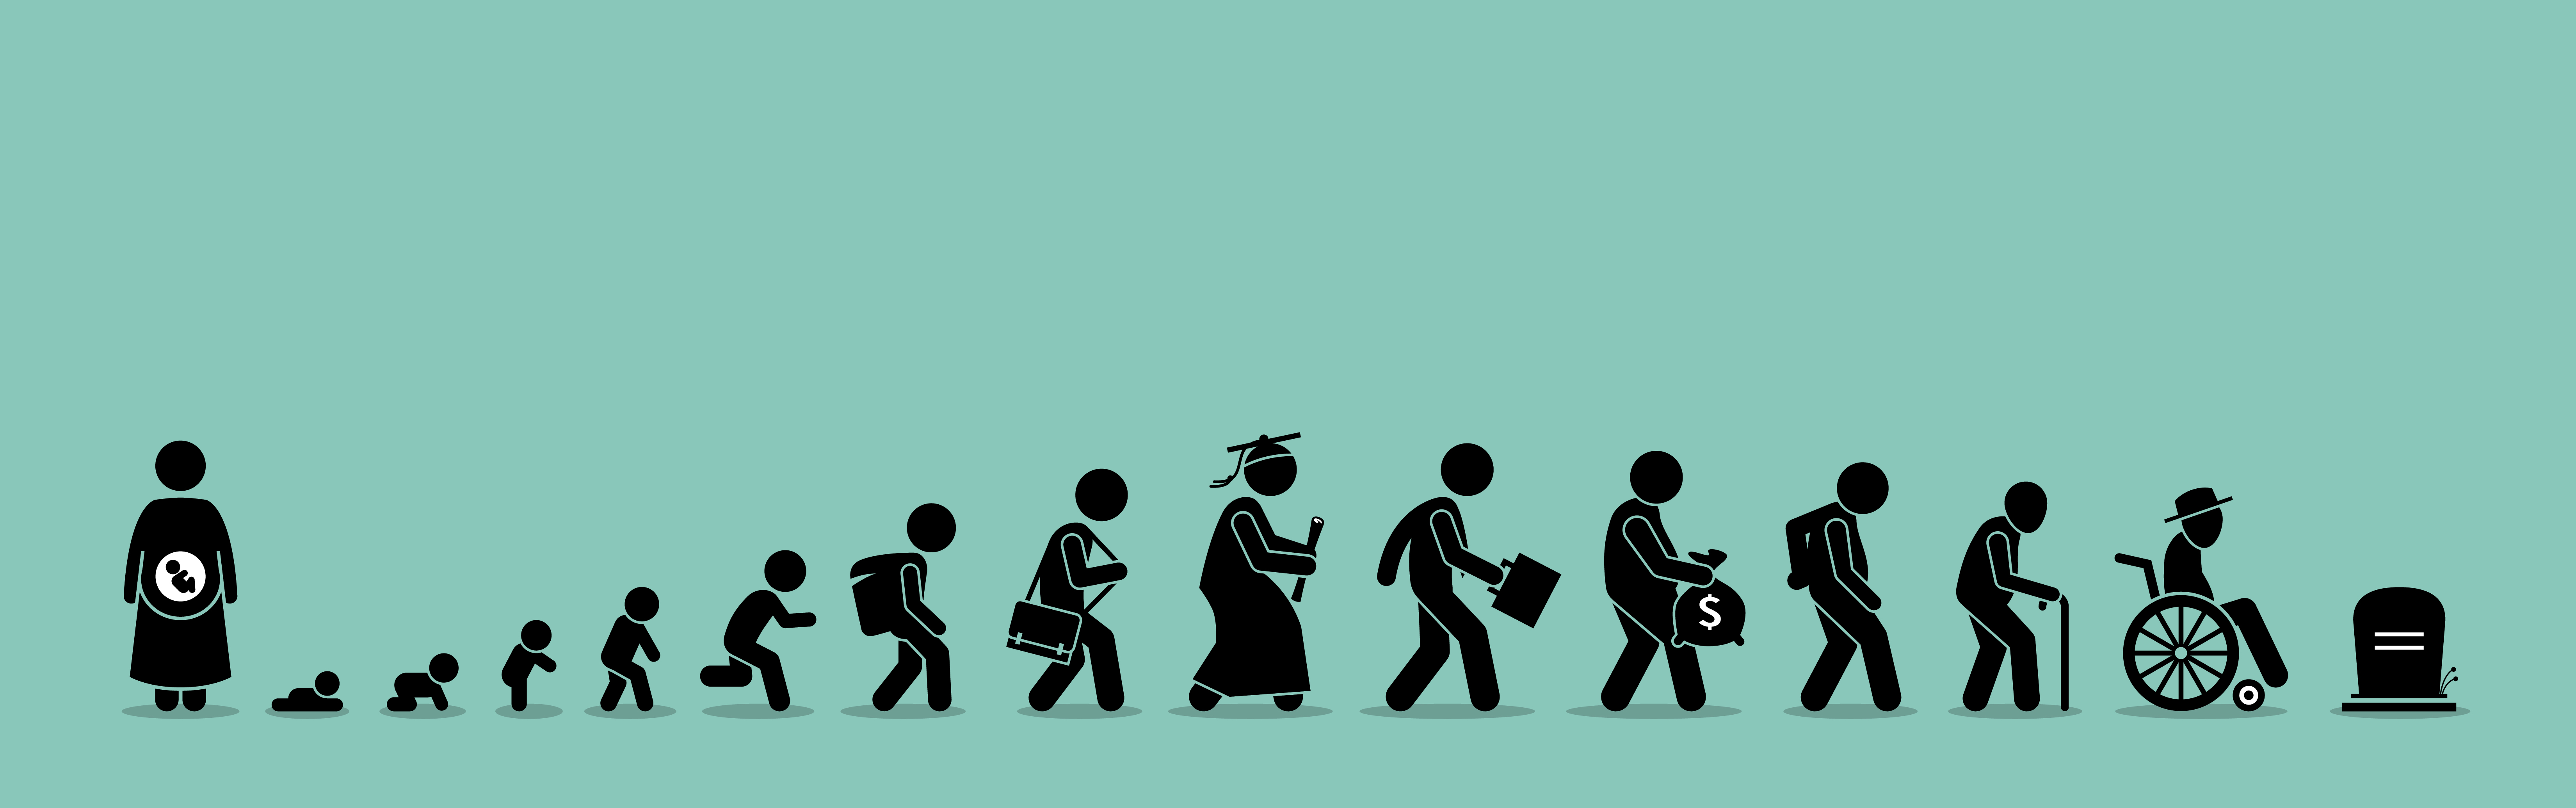

# **Content**


*   Introduction
*   About The Dataset
*   Import Necessary Lebraries
*   Load Dataset
*   Exploratory Data Anlysis
*   Feature Extraction

*   Model Development
*   Conclusion







# **Introduction**



Gender and age detection using images is a computer vision application that automatically identifies the gender and estimates the age of individuals in photographs or video frames. This technology relies on the power of image processing and deep learning models to make these predictions. It has applications in various fields, from targeted advertising to security and personalized user experiences.

# **About The Dataset**


The UTKFace dataset is an extensive collection of facial images that spans a wide range of ages, from newborns to individuals as old as 116 years. This dataset comprises more than 20,000 facial images, each meticulously annotated with information about age, gender, and ethnicity. The images exhibit significant diversity in terms of pose, facial expressions, lighting conditions, occlusions, image resolution, and other factors. Researchers and developers can employ this dataset for various purposes, including tasks like facial recognition, age prediction, age progression/regression modeling, and facial landmark identification, among others.

## **Import Libraries**

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od
import os
import seaborn as sns
import numpy as np
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.utils import load_img
from tqdm import tqdm
import random

## **Load dataset**

In [4]:
dataset = od.download(
                    "https://www.kaggle.com/datasets/jangedoo/utkface-new")

Skipping, found downloaded files in "./utkface-new" (use force=True to force download)


In [5]:
BASE_DIR = '/content/utkface-new/UTKFace'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

100%|██████████| 23708/23708 [00:00<00:00, 451654.71it/s]


In [6]:
age_count = len(age_labels)
gender_count = len(gender_labels)
image_count = len(image_paths)

print('Number of age_labels:',age_count)
print('Number of gender_labels:',gender_count)
print('Number of image_paths:',image_count)


Number of age_labels: 23708
Number of gender_labels: 23708
Number of image_paths: 23708


In [7]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [8]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,/content/utkface-new/UTKFace/22_1_1_2017011301...,22,1
1,/content/utkface-new/UTKFace/66_0_3_2017011719...,66,0
2,/content/utkface-new/UTKFace/1_1_2_20161219162...,1,1
3,/content/utkface-new/UTKFace/25_1_1_2017011717...,25,1
4,/content/utkface-new/UTKFace/6_1_3_20161220223...,6,1


In [9]:
desc_stats = df.describe().T

# Create a custom style for the DataFrame visualization
def custom_style(val):
    color = '#606ff2'
    return f'background-color: {color}; color: white'

# Apply the custom style to the whole DataFrame
styled_desc_stats = desc_stats.style.applymap(custom_style)

# Apply background gradient to 'std' column using 'PuBu' colormap
styled_desc_stats = styled_desc_stats.background_gradient(subset=['std'], cmap='PuBu')

# Apply background gradient to '50%' column using 'PuBu' colormap
styled_desc_stats = styled_desc_stats.background_gradient(subset=['50%'], cmap='PuBu')

# Display the styled descriptive statistics DataFrame
styled_desc_stats

,count,mean,std,min,25%,50%,75%,max
age,23708.000000,33.303484,19.886112,1.000000,23.000000,29.000000,45.000000,116.000000
gender,23708.000000,0.477349,0.499497,0.000000,0.000000,0.000000,1.000000,1.000000


In [10]:
import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['gender'], **{})
chart

# **Exploratory Data Anlysis**

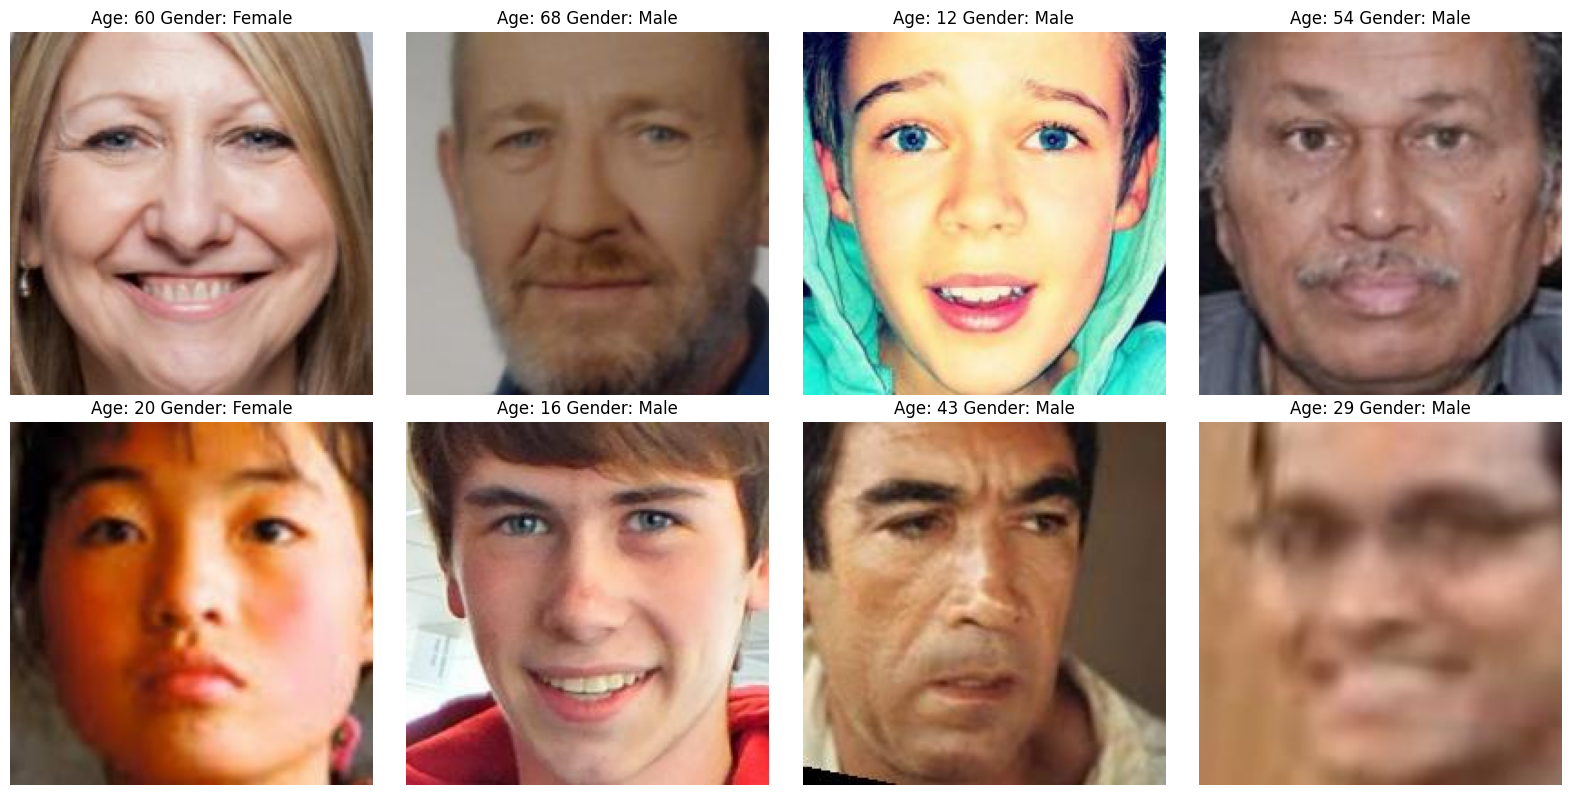

In [11]:
import random
from PIL import Image
import matplotlib.pyplot as plt

# Assuming 'image_paths' is a list of image file paths
num_images_to_plot = 8

plt.figure(figsize=(16, 8))  # Create a larger figure for multiple subplots


for i in range(num_images_to_plot):
    rand_index = random.randint(3, len(image_paths) - 1)  # Ensure the index is within the valid range
    age = df['age'][rand_index]
    gender = df['gender'][rand_index]
    image_path = df['image_path'][rand_index]

    IMG = Image.open(image_path)

    # Create subplots for each image
    plt.subplot(2, 4, i + 1)  # 2 rows, 4 columns
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.axis('off')
    plt.imshow(IMG)

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()


<ipython-input-12-996b1fd3e74f>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age'])


<Axes: xlabel='age', ylabel='Density'>

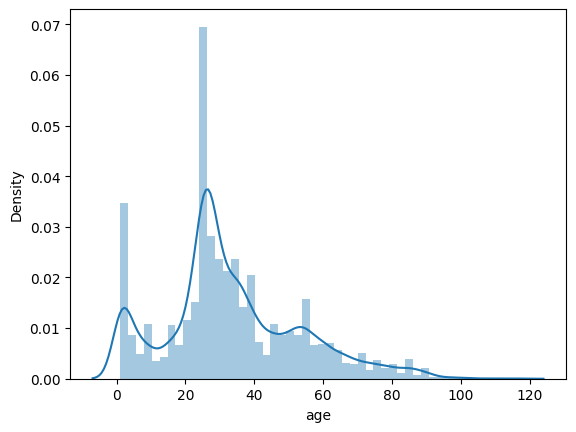

In [12]:
 # Age distribution
 sns.distplot(df['age'])

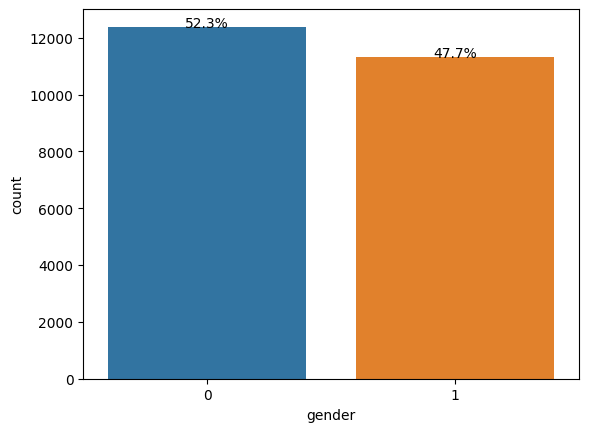

In [13]:
# Create a countplot for gender
ax = sns.countplot(x="gender", data=df)

# Calculate the total count of data points
total = len(df)

# Annotate the percentage on top of each bar
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')

plt.show()


# Feature Extraction

In [14]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [15]:

X = extract_image_features(df['image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(
<ipython-input-14-d36fd676b83e>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((128, 128), Image.ANTIALIAS)
100%|██████████| 23708/23708 [00:34<00:00, 682.17it/s]


In [16]:

X.shape

(23708, 128, 128, 1)

In [17]:
X = X / 255.0

In [18]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [19]:
input_shape = (128, 128, 1)


In [20]:
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy'])


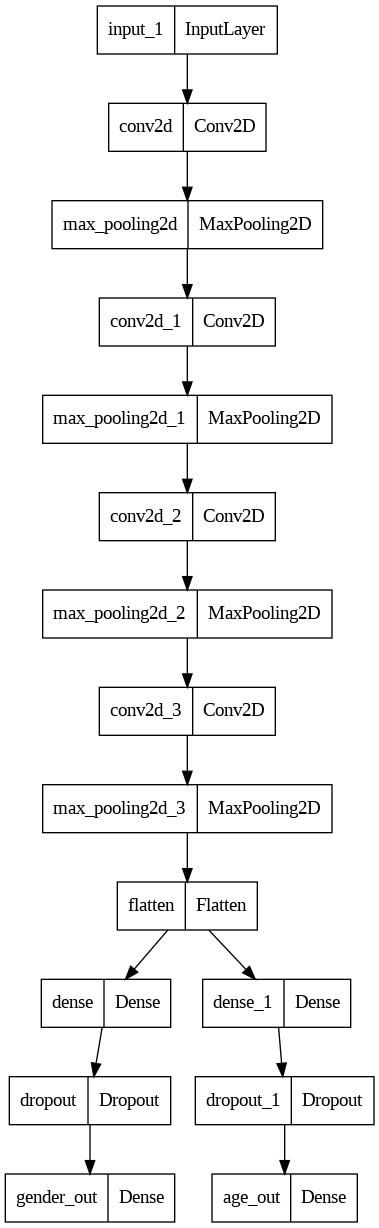

In [21]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [22]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=50, validation_split=0.2)

Epoch 1/50
593/593 [==============================] - 34s 23ms/step - loss: 15.7129 - gender_out_loss: 0.6666 - age_out_loss: 15.0463 - gender_out_accuracy: 0.5707 - age_out_accuracy: 0.0465 - val_loss: 12.2539 - val_gender_out_loss: 0.5351 - val_age_out_loss: 11.7189 - val_gender_out_accuracy: 0.7429 - val_age_out_accuracy: 0.0449
Epoch 2/50
593/593 [==============================] - 12s 21ms/step - loss: 10.9879 - gender_out_loss: 0.4853 - age_out_loss: 10.5026 - gender_out_accuracy: 0.7684 - age_out_accuracy: 0.0289 - val_loss: 9.8112 - val_gender_out_loss: 0.4123 - val_age_out_loss: 9.3989 - val_gender_out_accuracy: 0.8087 - val_age_out_accuracy: 0.0217
Epoch 3/50
593/593 [==============================] - 12s 20ms/step - loss: 9.4882 - gender_out_loss: 0.4044 - age_out_loss: 9.0839 - gender_out_accuracy: 0.8110 - age_out_accuracy: 0.0173 - val_loss: 9.0313 - val_gender_out_loss: 0.3672 - val_age_out_loss: 8.6641 - val_gender_out_accuracy: 0.8336 - val_age_out_accuracy: 0.0205
Epoc

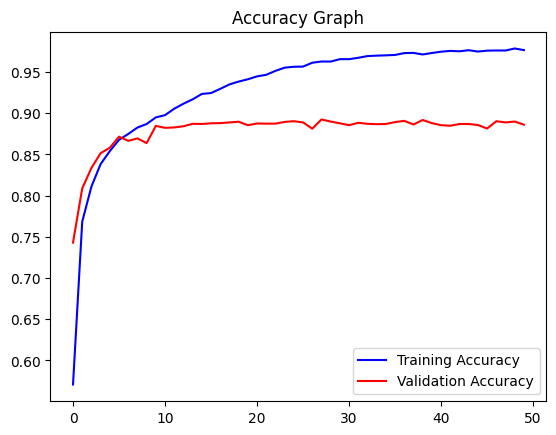

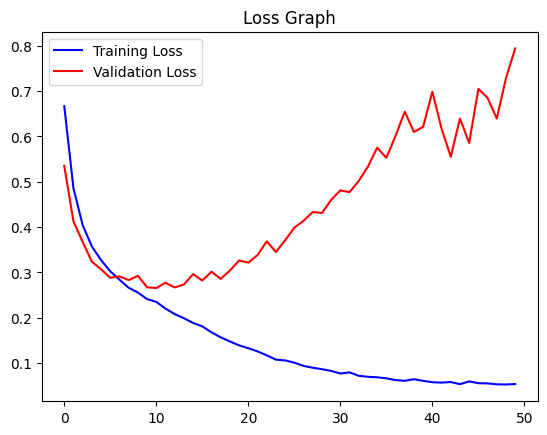

In [23]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

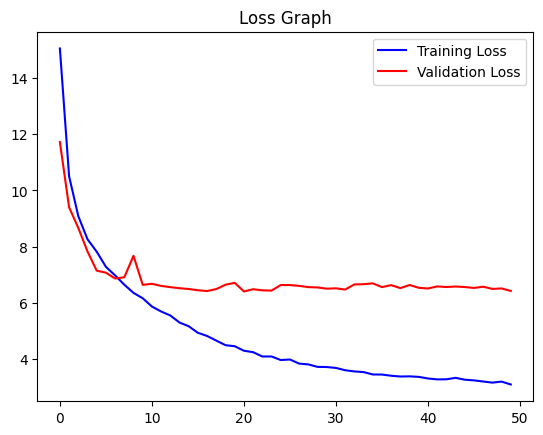

In [24]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


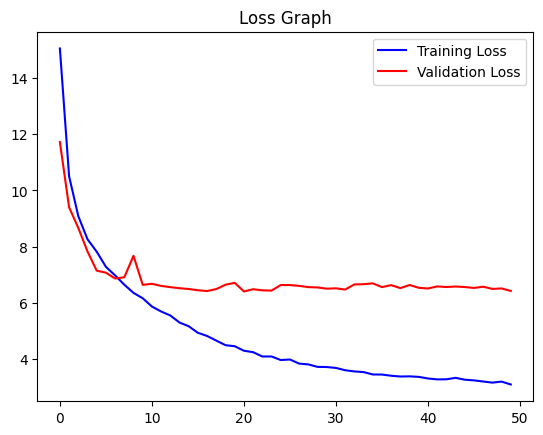

In [25]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Male Original Age: 35
1/1 [==============================] - 0s 214ms/step
Predicted Gender: Male Predicted Age: 34


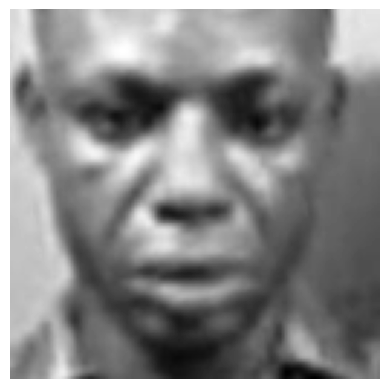

In [26]:
image_index = 100
print("Original Gender:", gender_mapping[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_mapping[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')

Original Gender: Male Original Age: 29
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Male Predicted Age: 29
Gender Accuracy: 1
Age Accuracy: 1


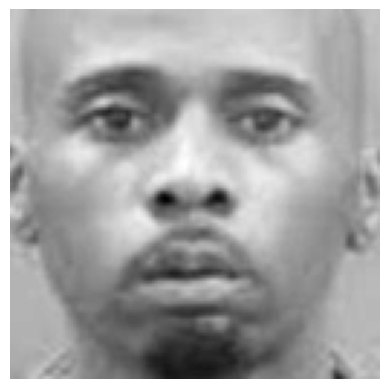

In [27]:
# Assuming you have the ground truth labels (y_gender and y_age) and the model (model) already defined

image_index = 12
print("Original Gender:", gender_mapping[y_gender[image_index]], "Original Age:", y_age[image_index])

# Predict from the model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_mapping[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)

# Calculate gender accuracy
gender_accuracy = 1 if pred_gender == gender_mapping[y_gender[image_index]] else 0

# Calculate age accuracy
age_accuracy = 1 if pred_age == y_age[image_index] else 0

print("Gender Accuracy:", gender_accuracy)
print("Age Accuracy:", age_accuracy)

# To display the image
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')


# **Conclusion**

In conclusion, the CNN (Convolutional Neural Network) project reached its final training epoch (Epoch 50/50) with the following notable statistics:

- The overall loss at the end of training is 3.1504, which is a measure of how well the model performed in making predictions.
- For gender prediction (gender_out), the loss is 0.0536, and the accuracy is quite high at 97.67%, indicating the model's proficiency in determining gender.
- Age prediction (age_out) demonstrates a higher loss of 3.0968 and a lower accuracy of 4.40%, suggesting a more challenging task and room for improvement.
- On the validation set, the results differ slightly with a total loss of 7.2176.
- Gender prediction remains strong with a loss of 0.7939 and an accuracy of 88.61%.
- Age prediction, on the other hand, yields a higher loss of 6.4237 and a low accuracy of 4.85%, indicating that the model may not generalize well to unseen data.

These metrics provide insights into the model's performance, highlighting the areas where it excels (gender prediction) and where there may be opportunities for further refinement (age prediction). The project's success will depend on the specific goals and requirements, and further fine-tuning may be necessary to enhance age prediction accuracy.